In [1]:
from config import *

from easyric.caas_lite import TiffSpliter
from easyric.objects import Pix4D
from easyric.io import shp, geotiff, plot
from easyric.calculate import geo2raw, geo2tiff

import os
import shapefile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import tifffile



In [2]:
p2 = Paths("210526", year=2021)

p4d = Pix4D(project_path=p2.pix4d_project, 
            raw_img_path=p2.raw_img, 
            project_name=p2.project_name,
            param_folder=p2.pix4d_param)

#root = shapefile.Reader(f"{p2.root}/10_locate_by_cv/color_label_0417_mavic/keep_points_manual.shp")
root = shapefile.Reader(f"{p2.root}/12_locate_by_yolo/sorted_id.shp")
points_np = np.zeros((0,2))
for i, point in enumerate(root.shapes()):
    points_np = np.vstack([points_np, np.asarray(point.points)])

[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]
[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]


In [3]:
ht = geotiff.mean_values(p4d.dsm_file)

[io][geotiff][GeoCorrd] Comprehense [* 34737 geo_ascii_params (30s) b'WGS 84 / UTM zone 54N|WGS 84|'] to geotiff coordinate tag [WGS 84 / UTM zone 54N]


In [6]:
ht

96.56021707219598

In [4]:
points_np3d = np.insert(points_np, 2, ht, axis=1)

In [7]:
points_np3d

array([[3.68098891e+05, 3.95606599e+06, 9.65602171e+01],
       [3.68099467e+05, 3.95606659e+06, 9.65602171e+01],
       [3.68099008e+05, 3.95606561e+06, 9.65602171e+01],
       ...,
       [3.68126759e+05, 3.95602394e+06, 9.65602171e+01],
       [3.68125243e+05, 3.95602122e+06, 9.65602171e+01],
       [3.68112896e+05, 3.95601753e+06, 9.65602171e+01]])

In [5]:
points = shp.read_shp3d(f"{p2.root}/12_locate_by_yolo/sorted_id.shp", p4d.dsm_file, get_z_by="max", get_z_buffer=0.2, geo_head=p4d.dsm_header)

[io][shp][fields] Shp fields: {'name': 0}
[io][shp][proj] could not find ESRI projection file Y:\hwang_Pro\data\2021_tanashi_broccoli/12_locate_by_yolo/sorted_id.prj, could not operate auto-convention, Please convert projection system manually.
[io][shp][name] Loading Z values from DSM, this may take a while


{'0': array([[3.68098891e+05, 3.95606599e+06, 9.70373840e+01]]),
 '1': array([[3.68099467e+05, 3.95606659e+06, 9.69959106e+01]]),
 '2': array([[3.68099008e+05, 3.95606561e+06, 9.70952148e+01]]),
 '3': array([[3.68100563e+05, 3.95606502e+06, 9.70549316e+01]]),
 '4': array([[3.68101511e+05, 3.95606724e+06, 9.68239059e+01]]),
 '5': array([[3.68098771e+05, 3.95606638e+06, 9.69722290e+01]]),
 '6': array([[3.68100460e+05, 3.95606578e+06, 9.71611328e+01]]),
 '7': array([[3.68099966e+05, 3.95606443e+06, 9.75303650e+01]]),
 '8': array([[3.68100926e+05, 3.95606634e+06, 9.66230545e+01]]),
 '9': array([[3.68100642e+05, 3.95606468e+06, 9.70641327e+01]]),
 '10': array([[3.68101016e+05, 3.95606599e+06, 9.68214569e+01]]),
 '11': array([[3.68099677e+05, 3.95606585e+06, 9.70581131e+01]]),
 '12': array([[3.68100114e+05, 3.95606373e+06, 9.70846100e+01]]),
 '13': array([[3.68099195e+05, 3.95606451e+06, 9.69941559e+01]]),
 '14': array([[3.68100996e+05, 3.95606326e+06, 9.70187531e+01]]),
 '15': array([[3.681

In [10]:
points_np3d_new = np.zeros((0,3))
for k, p in points.items():
    points_np3d_new = np.vstack([points_np3d_new, p])
    
points_np3d_new

array([[3.68098891e+05, 3.95606599e+06, 9.70373840e+01],
       [3.68099467e+05, 3.95606659e+06, 9.69959106e+01],
       [3.68099008e+05, 3.95606561e+06, 9.70952148e+01],
       ...,
       [3.68126759e+05, 3.95602394e+06, 9.71841812e+01],
       [3.68125243e+05, 3.95602122e+06, 9.66178055e+01],
       [3.68112896e+05, 3.95601753e+06, 9.66947632e+01]])

In [11]:
deeplab_dict = {}
for img in p4d.img:
    points_raw = geo2raw.pmatrix_calc(p4d, points_np3d-p4d.offset.np, img.name, distort_correct=True)
    
    points_left = points_raw[(points_raw[:,0] > 0) & (points_raw[:,0] < img.w) & 
                             (points_raw[:,1] > 0) & (points_raw[:,1] < img.h), :]
    
    if len(points_left) > 0:
        deeplab_dict[img.name] = {"imagePath": img.path,
                                  "points": points_left.tolist()}

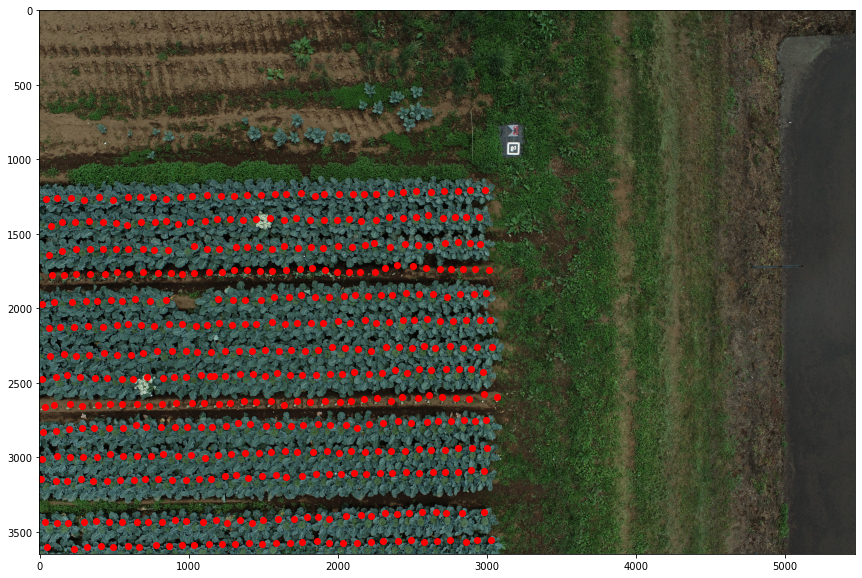

In [9]:
plt.figure(figsize=(15,10))
plt.imshow(plt.imread(deeplab_dict["DJI_0045.JPG"]["imagePath"]))
plt.scatter(*np.asarray(deeplab_dict["DJI_0045.JPG"]["points"]).T, color='r')

In [21]:
from easyric.io.json import dict2json

In [22]:
dict2json(deeplab_dict, f"{p2.root}/11_labelme_json/{p2.project_name}.json")

[io][json] Save Json file -> Y:\hwang_Pro\data\2020_tanashi_broccoli\11_labelme_json\broccoli_tanashi_5_20200518_P4M_10m.json


In [12]:
deeplab_dict_new = {}
for img in p4d.img:
    points_raw = geo2raw.pmatrix_calc(p4d, points_np3d_new-p4d.offset.np, img.name, distort_correct=True)
    
    points_left = points_raw[(points_raw[:,0] > 0) & (points_raw[:,0] < img.w) & 
                             (points_raw[:,1] > 0) & (points_raw[:,1] < img.h), :]
    
    if len(points_left) > 0:
        deeplab_dict_new[img.name] = {"imagePath": img.path,
                                      "points": points_left.tolist()}

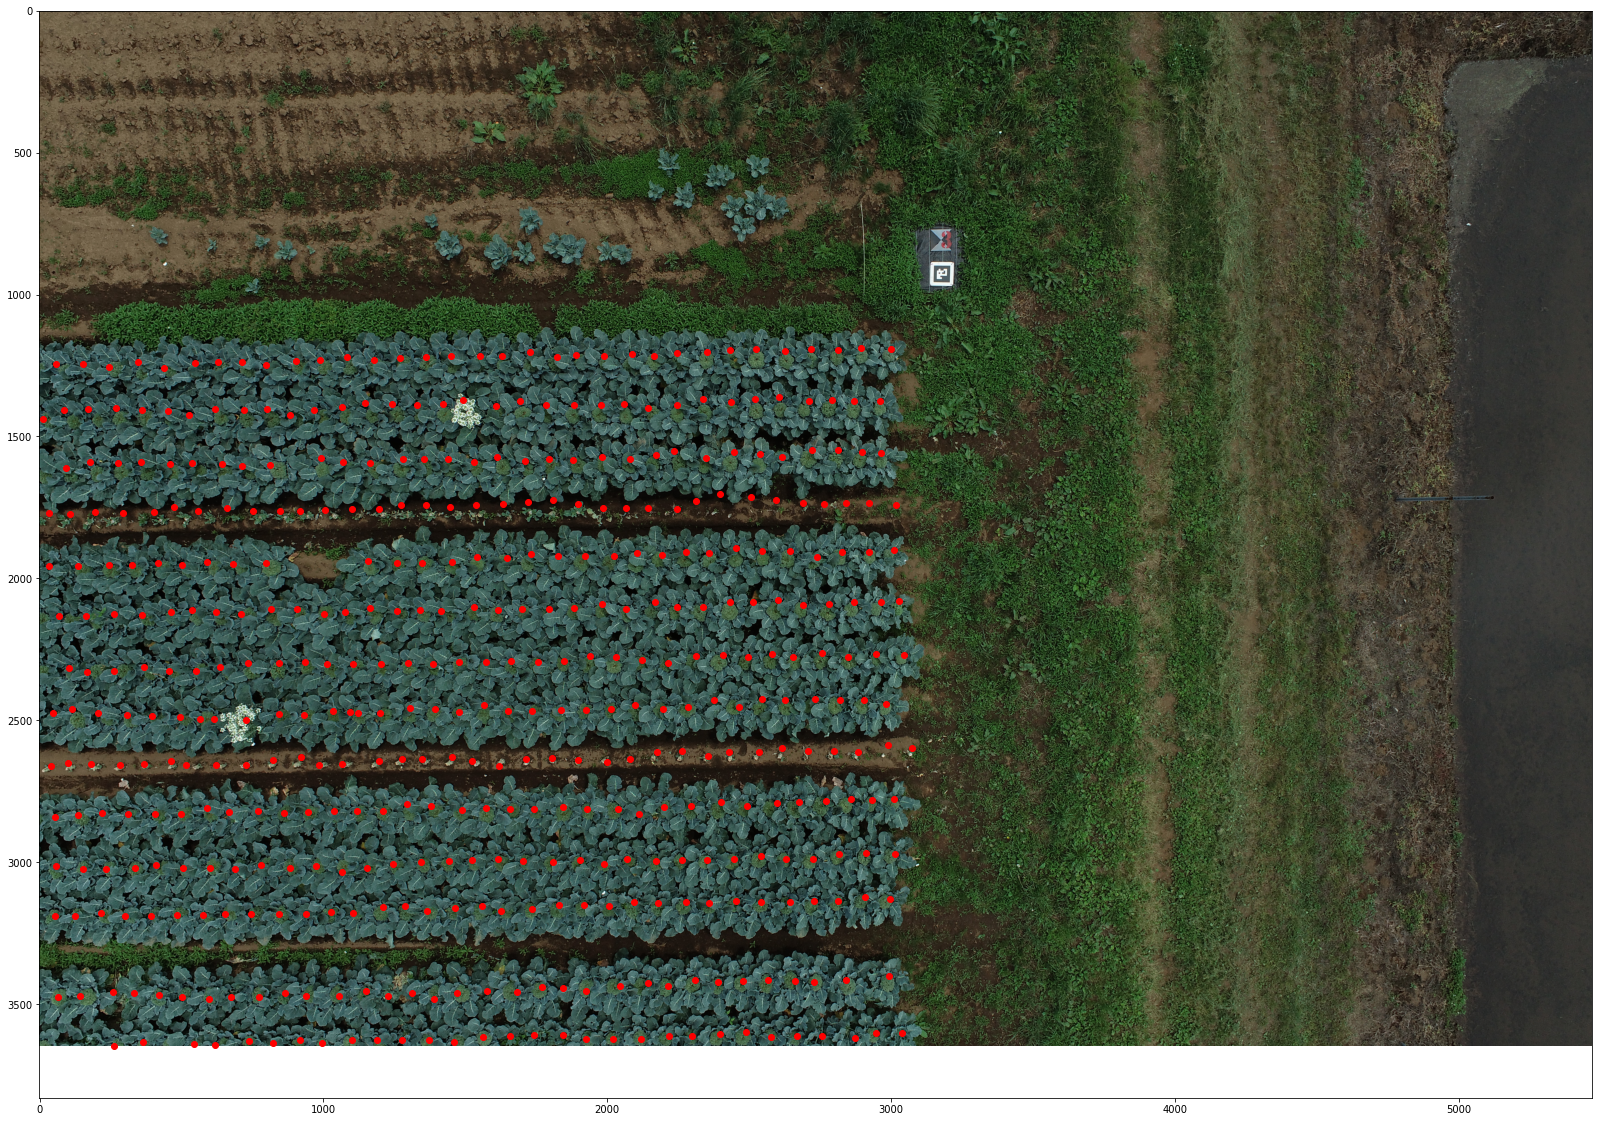

In [15]:
plt.figure(figsize=(30,20))
plt.imshow(plt.imread(deeplab_dict_new["DJI_0045.JPG"]["imagePath"]))
plt.scatter(*np.asarray(deeplab_dict_new["DJI_0045.JPG"]["points"]).T, color='r')

In [ ]:
fmt = 'name="char_017_3#10", fadetime=1.4'